In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv('sample.csv')

In [3]:
data.head()

,blocked,paid,submission_id,project_id,time_start,time_end,latitude,longitude,status,reject_reason,user_id,role
0,False,False,199999,2330,43299.23857,NaN,23.5,128.1,progress,NaN,430,normal_bee
1,False,False,199998,2278,43297.55245,NaN,-12.3,7.1,progress,NaN,518,normal_bee
2,False,False,199997,2278,43296.82781,NaN,48.9,-28.2,progress,NaN,348,normal_bee
3,False,False,199996,2278,43296.82016,NaN,40.8,126.9,progress,NaN,94,normal_bee
4,False,True,199995,2211,43291.89630,43291.89638,34.4,95.6,progress,NaN,96,normal_bee


# Getting insights from written rejection reasons

In [45]:
for e in data.reject_reason:
    if isinstance(e, str):
        print(e)

Blank submission.
Sorry we found irrelevant choices in your answer, therefore your task will be rejected.
Unfortunately you have not uploaded any image.
Unfortunately you have not uploaded any image.
Sorry we found irrelevant choices in your answer, therefore your task will be rejected.
Unfortunately you have not uploaded any image.
Irrelevent image.
Stock image.
Answer are not in detail.
Unfortunately you have not uploaded any image.
not new
Unfortunately you have not uploaded any image.
Irrelevent image.
Unfortunately you have not uploaded any image.
Unfortunately you have not uploaded any image.
Answer does not match with the criteria.
Answer are not in detail.
Unfortunately you have not uploaded any image.
Unfortunately you have not uploaded any image.
Answer are not in detail.
You must show Healthy snack bar therefore your submission will be rejected. Thank you.
Unfortunately you have not uploaded any image.
You must show Healthy snack bar therefore your submission will be rejecte

In [46]:
from wordcloud import WordCloud

In [47]:
text = []
for e in data.reject_reason:
    if isinstance(e, str):
        text.append(e)

In [48]:
whole_text = '\n'.join(text)

In [51]:
wordcloud = WordCloud().generate(whole_text)

(-0.5, 399.5, 199.5, -0.5)

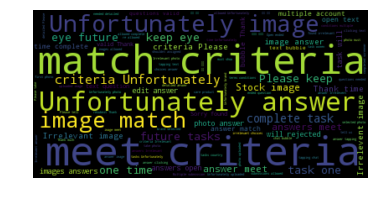

In [52]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

Could use this to get more information:
https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

## Creation of informative variables

### Target: low-quality submissions

In [4]:
low_quality = (data.status == 'resubmit') + (data.status == 'not_approved')

/home/avadmin/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [5]:
low_quality_share = sum(low_quality)/data.shape[0] * 100
print('%.2f percent of the submissions are low-quality.' % low_quality_share)

11.06 percent of the submissions are low-quality.


In [6]:
data['low_quality'] = low_quality

## Timezone

See https://github.com/pegler/pytzwhere

In [15]:
from tzwhere import tzwhere
tz = tzwhere.tzwhere(forceTZ=True)

In [23]:
sum(data.latitude.isna())

sum(data.longitude.isna())

2723

In [35]:
time_zone = []
for i, (lat, long) in enumerate(zip(data.latitude, data.longitude)):
    if not np.isnan(lat) and not np.isnan(long):
        try:
            time_zone.append(tz.tzNameAt(lat, long, forceTZ=True))
        except KeyError:
            time_zone.append(np.nan)
    else:
        time_zone.append(np.nan)
time_zone = np.array(time_zone)

## Count of previous submissions

In [65]:
users = data.user_id.unique()
print('There are %i users listed in the dataset.' % len(users))

There are 500 users listed in the dataset.


In [68]:
user_masks_and_counts = {}
for user in users:
    user_masks_and_counts[user] = {}
    mask = data.user_id == user
    user_masks_and_counts[user]['mask'] = mask
    user_masks_and_counts[user]['count'] = sum(mask)

In [71]:
submission_counts = np.empty(data.shape[0])
for user in users:
    mask = user_masks_and_counts[user]['mask']
    submission_counts[mask] = user_masks_and_counts[user]['count']

In [73]:
data['submission_counts'] = submission_counts

## Submission rate (submissions per unit of time)

## Time at location

In [78]:
import pytz
from datetime import datetime

def convert_timestamp_in_datetime_at_tz(timestamp_received):
    dt_naive_utc = datetime.utcfromtimestamp(timestamp_received)
    return dt_naive_utc.replace(tzinfo=pytz.utc)

In [79]:
convert_timestamp_in_datetime_at_tz(data.time_start[0])

datetime.datetime(1970, 1, 1, 12, 1, 39, 238570, tzinfo=<UTC>)